## Create deep neural network for classification CIFAR10 dataset and find confusion matrix.

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# Augment
transform_train = transforms.Compose([transforms.Resize((32,32)), 
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),    
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), 
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
 
 
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Data augmentation is only done on training images
training_dataset = datasets.CIFAR10(root='./data', 
                                    train=True, 
                                    download=True, 
                                    transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', 
                                      train=False, 
                                      download=True, 
                                      transform=transform)
 
training_loader = torch.utils.data.DataLoader(training_dataset, 
                                              batch_size=100, 
                                              shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size = 100, 
                                                shuffle=False)

In [3]:
def im_convert(tensor):  
  image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

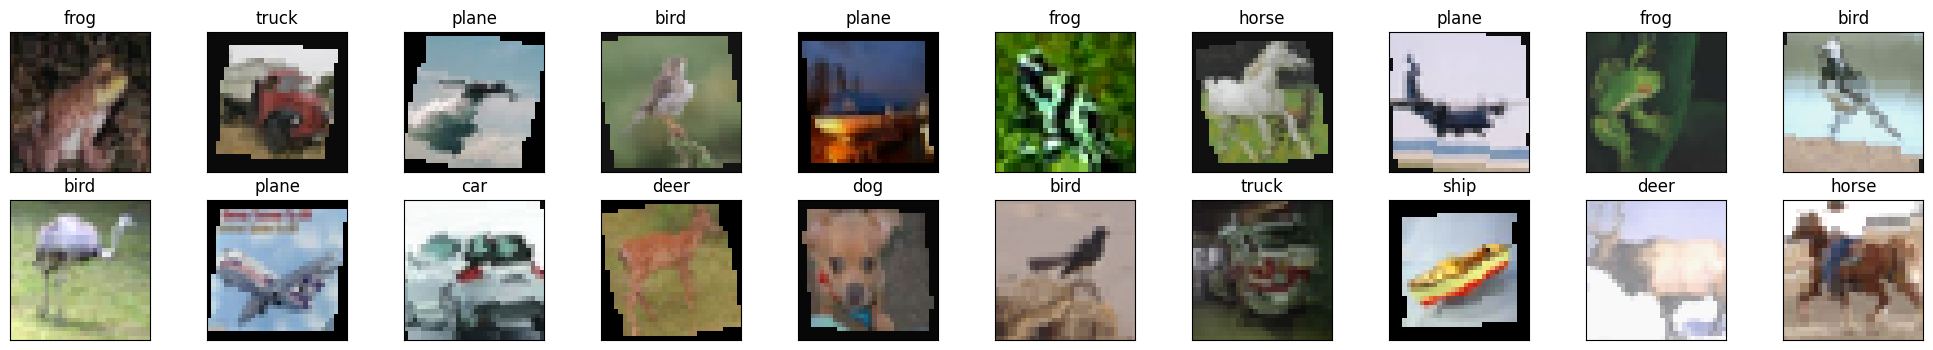

In [5]:
# dataiter = iter(training_loader) 
images, labels = next(iter(training_loader))
# a = next(iter(train_loader))
fig = plt.figure(figsize=(25, 4)) 

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) 
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

### **Model**

In [6]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500) 
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10) 

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2) 
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64) 
      x = F.relu(self.fc1(x))
      x = self.dropout1(x) 
      x = self.fc2(x)
      return x

In [7]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

### **Training Loop**

In [9]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

y_true = []
y_pred = []
y_pred_proba = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device) 
    labels = labels.to(device)
    outputs = model(inputs) 
    loss = criterion(outputs, labels) 
    
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data) 

  else:
    with torch.no_grad(): 
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)

        # Store predictions, true labels, and probabilities
        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(val_preds.cpu().numpy())
        y_pred_proba.extend(val_outputs.cpu().numpy())
      
    epoch_loss = running_loss/len(training_loader) 
    epoch_acc = running_corrects.float()/ len(training_loader) 
    running_loss_history.append(epoch_loss) 
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.6946, acc 37.7160 
validation loss: 1.4127, validation acc 48.5800 
epoch : 2
training loss: 1.4098, acc 48.8080 
validation loss: 1.2735, validation acc 54.0000 
epoch : 3
training loss: 1.2721, acc 54.4120 
validation loss: 1.1469, validation acc 58.9900 
epoch : 4
training loss: 1.1835, acc 57.7740 
validation loss: 1.1056, validation acc 60.7900 
epoch : 5
training loss: 1.1066, acc 60.7040 
validation loss: 1.0261, validation acc 63.8500 
epoch : 6
training loss: 1.0637, acc 62.4460 
validation loss: 0.9676, validation acc 66.0800 
epoch : 7
training loss: 1.0275, acc 63.8380 
validation loss: 0.9651, validation acc 66.3900 
epoch : 8
training loss: 0.9815, acc 65.4180 
validation loss: 0.8827, validation acc 69.7700 
epoch : 9
training loss: 0.9504, acc 66.5220 
validation loss: 0.9017, validation acc 68.8400 
epoch : 10
training loss: 0.9280, acc 67.4940 
validation loss: 0.8649, validation acc 70.3500 
epoch : 11
training loss: 0.8971, acc 68.4660 
va

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[10758   434   835   264   223   186   150   298  1247   605]
 [  401 12117    79   171    36    74   124   144   390  1464]
 [ 1161   151  7445   950  1431  1524  1004   782   290   262]
 [  334   157  1021  6275   769  3811  1113   873   309   338]
 [  426    98  1201   867  8074   985  1059  1949   254    87]
 [  205    72   766  2135   633  9401   353  1126   147   162]
 [   99   117   766  1052   856   662 10879   254   124   191]
 [  232    50   424   544   684  1256   134 11358    61   257]
 [ 1422   729   215   207   129   136    97   114 11459   492]
 [  536  1896    90   224    80   163   210   381   469 10951]]
              precision    recall  f1-score   support

           0       0.69      0.72      0.70     15000
           1       0.77      0.81      0.79     15000
           2       0.58      0.50      0.53     15000
           3       0.49      0.42      0.45     15000
           4       0.63      0.54      0.58     15000
           5       0.52      0.63      0.57 

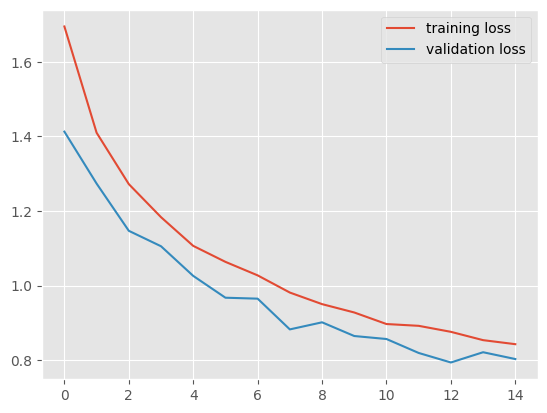

In [11]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

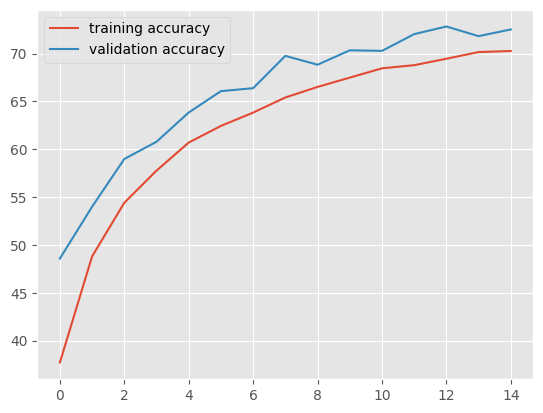

In [12]:
running_corrects_history_tensor = torch.tensor(running_corrects_history)
val_running_corrects_history_tensor = torch.tensor(val_running_corrects_history)

plt.style.use('ggplot')
plt.plot(running_corrects_history_tensor.cpu().numpy(), label='training accuracy')
plt.plot(val_running_corrects_history_tensor.cpu().numpy(), label='validation accuracy')
plt.legend()